In [1]:
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import numpy as np
import matplotlib.pyplot as plt
from backtester.backtester import Backtester
from backtester.strategy import Strategy
from backtester.portfolio import Portfolio
from historical_data.alpaca import AlpacaHistoricalData
from historical_data.yfinance import HistoricalData
import talib as ta
from alpaca.data.timeframe import TimeFrameUnit

In [2]:
assets = ["MET", "NFLX","GOOG","AMZN"]
asset_weights = [1, 2, 3, 4]
assetType = 'Stock'
short_start = '2024-01-01'
short_end = '2024-12-29'
short_interval = '1h'
alpaca_interval = 1
alpaca_unit = TimeFrameUnit.Hour

short_period = 12
long_period = 26
longer_period = 200
atr_period = 14
commission_percentage = 0.00
stop_loss_multiplier = None
take_profit_multiplier = None
amount_invested = 1000
leverage = 1
longer_ema_offset = 0

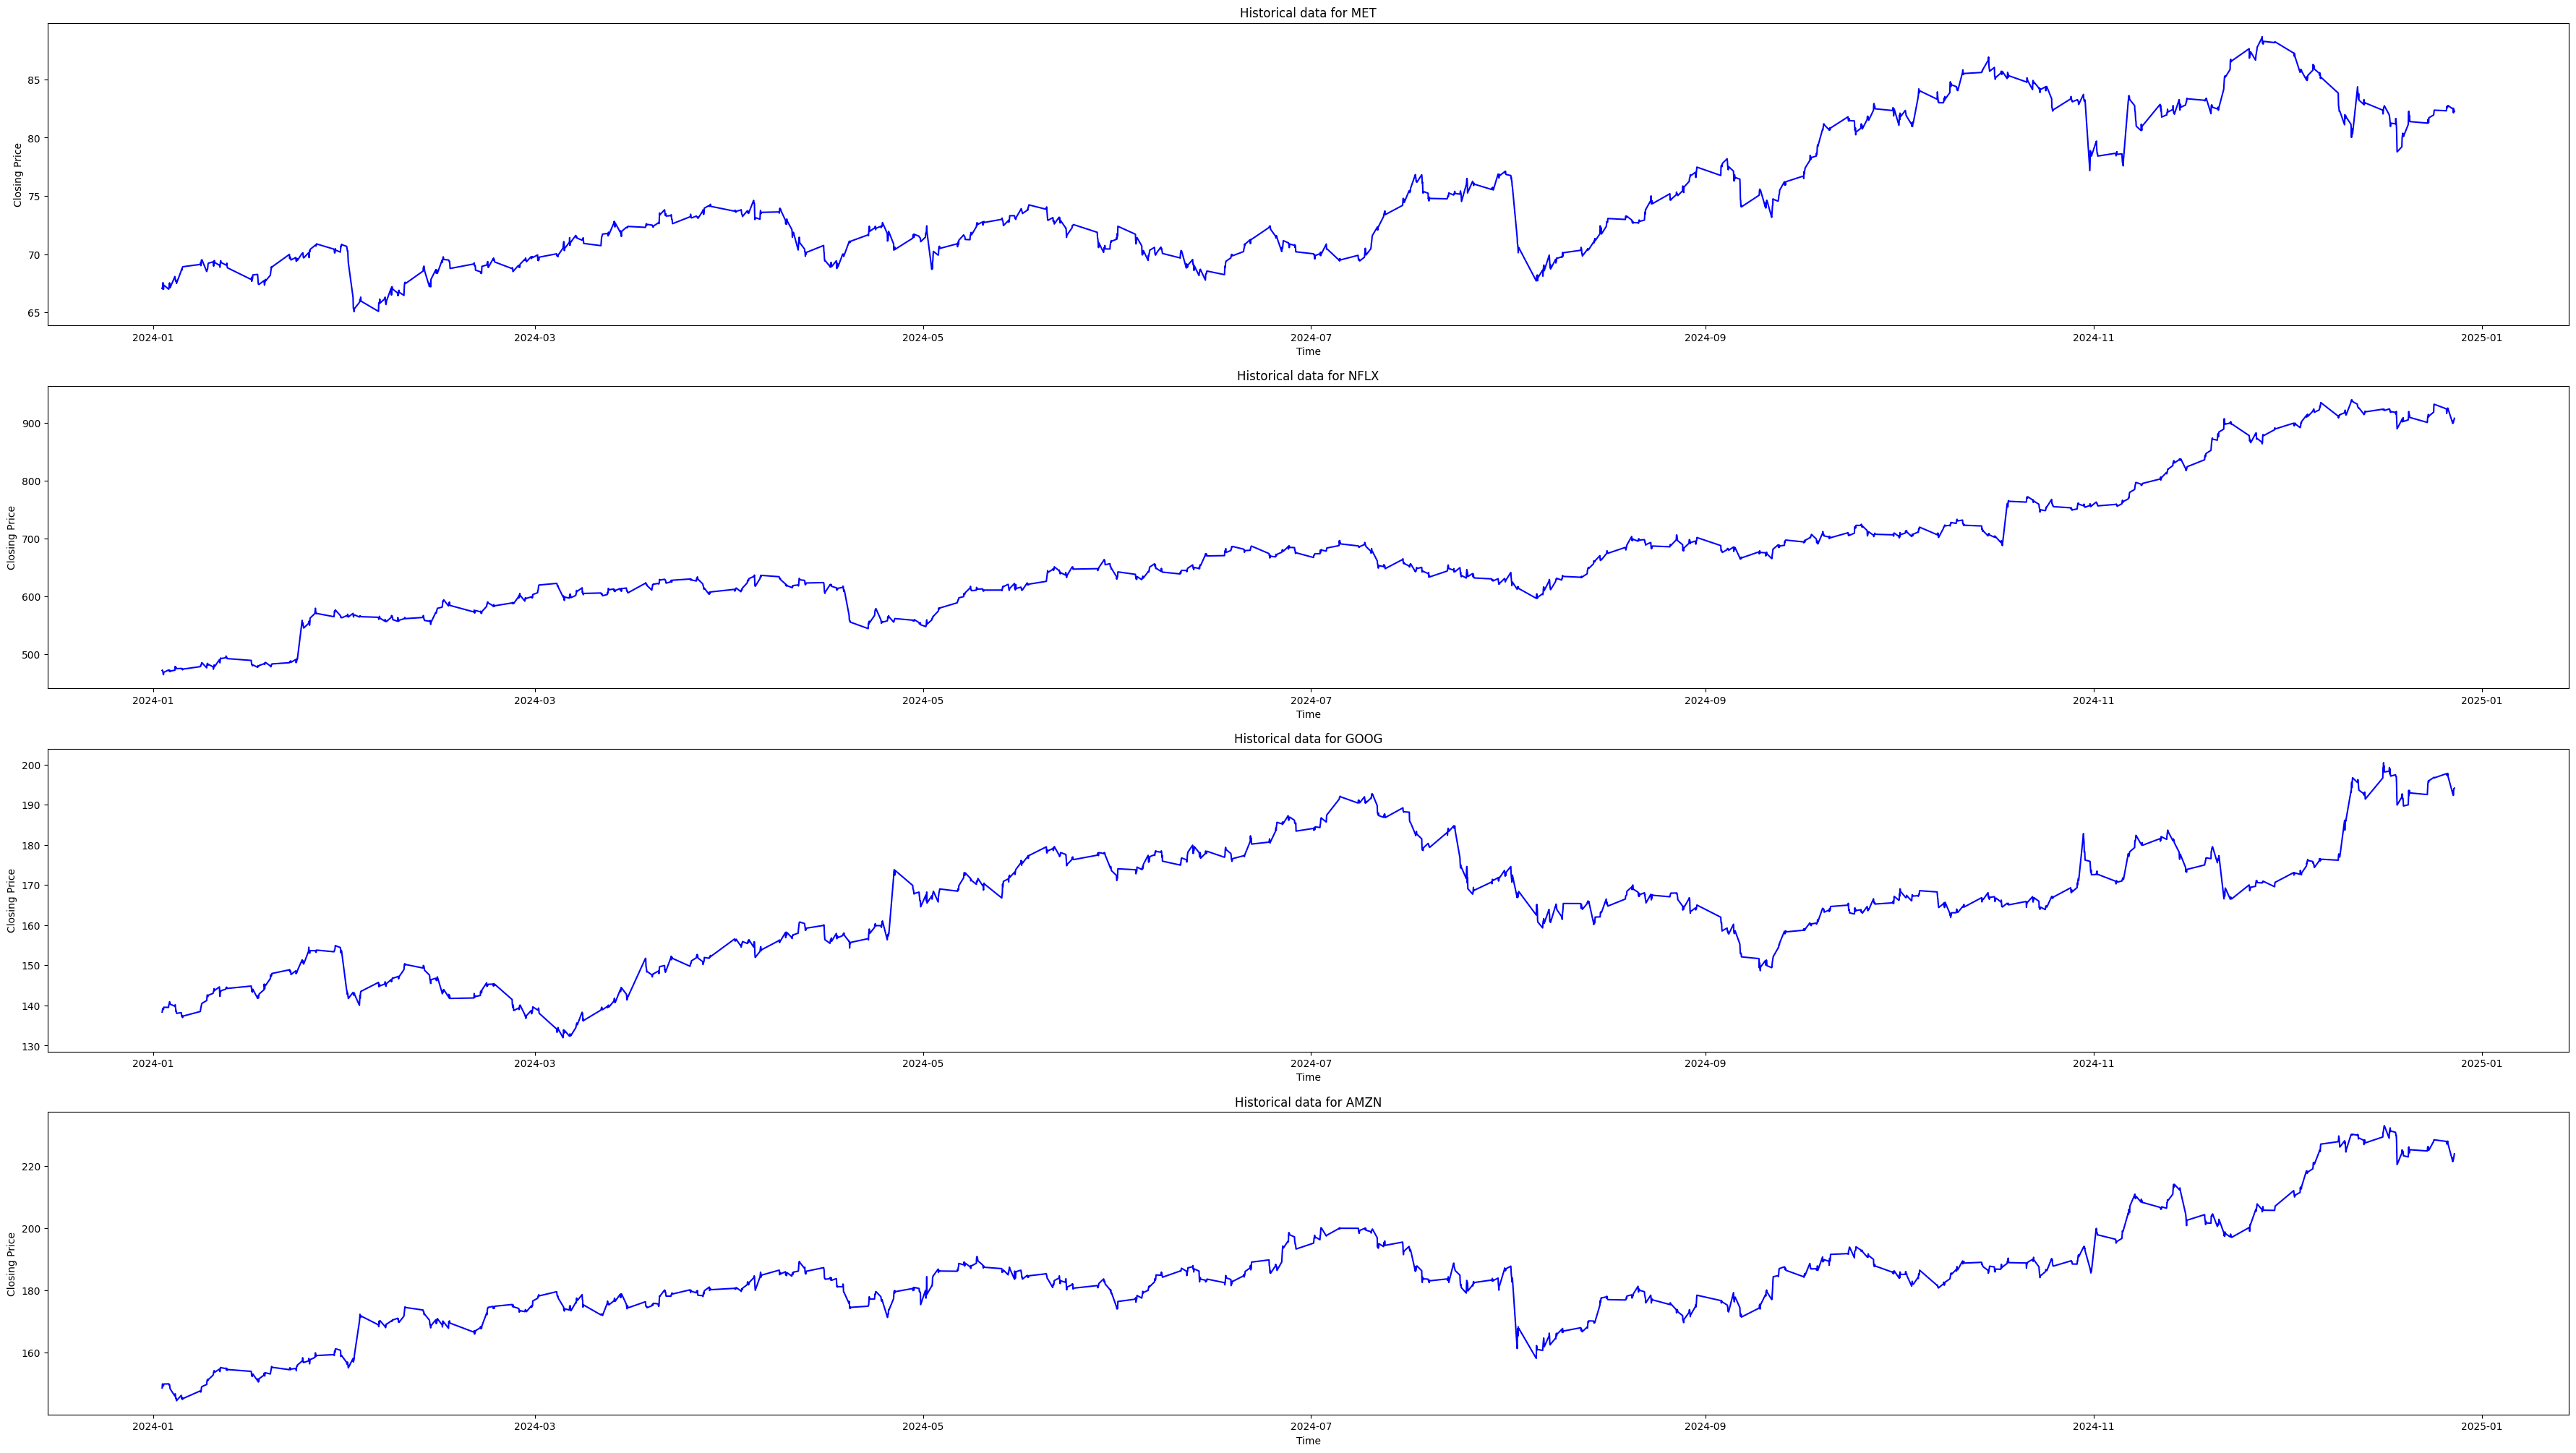

In [3]:
# historical_data = AlpacaHistoricalData(assets, assetType, short_start, short_end, alpaca_interval, alpaca_unit)
historical_data = HistoricalData(assets, short_start, short_end, short_interval)
data = historical_data.get_data()
historical_data.plot_data()

In [4]:
import pandas as pd
from backtester.position import Position


class EMACrossoverLongStrategy(Strategy):
    def __init__(self, short_period, long_period, longer_period, atr_period, longer_ema_offset):
        self.short_period = short_period
        self.long_period = long_period
        self.longer_period = longer_period
        self.atr_period = atr_period
        self.longer_ema_offset = longer_ema_offset
        
    def initialize_indicators(self, data):
        self.short_ema = ta.EMA(data['Close'], self.short_period)
        self.long_ema = ta.EMA(data['Close'], self.long_period)
        self.atr = ta.ATR(data['High'], data['Low'], data['Close'], self.atr_period)
        self.longer_ema = ta.SMA(data['Close'], self.longer_period) + (self.longer_ema_offset*self.atr)
        self.previous_short_ema = self.short_ema.shift()
        self.previous_long_ema = self.long_ema.shift()
        self.close = data['Close']
        self.data = data
             
    def generate_positions(self, data): # long strategy
        position = pd.Series(None, data.index)
        position_checker = (self.short_ema > self.long_ema) & \
            (self.previous_short_ema <= self.previous_long_ema) & \
            (self.close > self.longer_ema)
        position = np.where(position_checker, Position.BUY,
                                np.where(((self.short_ema < self.long_ema) & \
                                    (self.previous_short_ema >= self.previous_long_ema)), Position.CLOSE, None))
        return position
    
    # def generate_positions(self, data): # short strategy
    #     position = pd.Series(None, data.index)
    #     position_checker = (self.short_ema < self.long_ema) & \
    #         (self.previous_short_ema >= self.previous_long_ema) & \
    #         (self.close < self.longer_ema)
    #     position = np.where(position_checker, Position.SELL,
    #                             np.where(((self.short_ema > self.long_ema) & \
    #                                 (self.previous_short_ema <= self.previous_long_ema)), Position.CLOSE, None))
    #     return position

    def plot_indicators(self):
        _, axis = plt.subplots(1, figsize=(45, 15))
        axis.set_title("Close Price Series with Crossovers")
        axis.plot(self.close.index, self.close, color='black')
        axis.plot(self.short_ema.index, self.short_ema, color='blue')
        axis.plot(self.long_ema.index, self.long_ema, color='green')
        axis.plot(self.longer_ema.index, self.longer_ema, color='red')
        plt.show()

In [5]:
portfolio = Portfolio(assets=assets, asset_weights=asset_weights, initial_amount=1000, commission_fee=commission_percentage, leverage=leverage)
strategy = EMACrossoverLongStrategy(short_period, long_period, longer_period, atr_period, longer_ema_offset=longer_ema_offset)
backtester = Backtester(portfolio=portfolio, data=data, strategy=strategy, stop_loss_multiplier=stop_loss_multiplier, \
    take_profit_multiplier=take_profit_multiplier)
backtester.run()


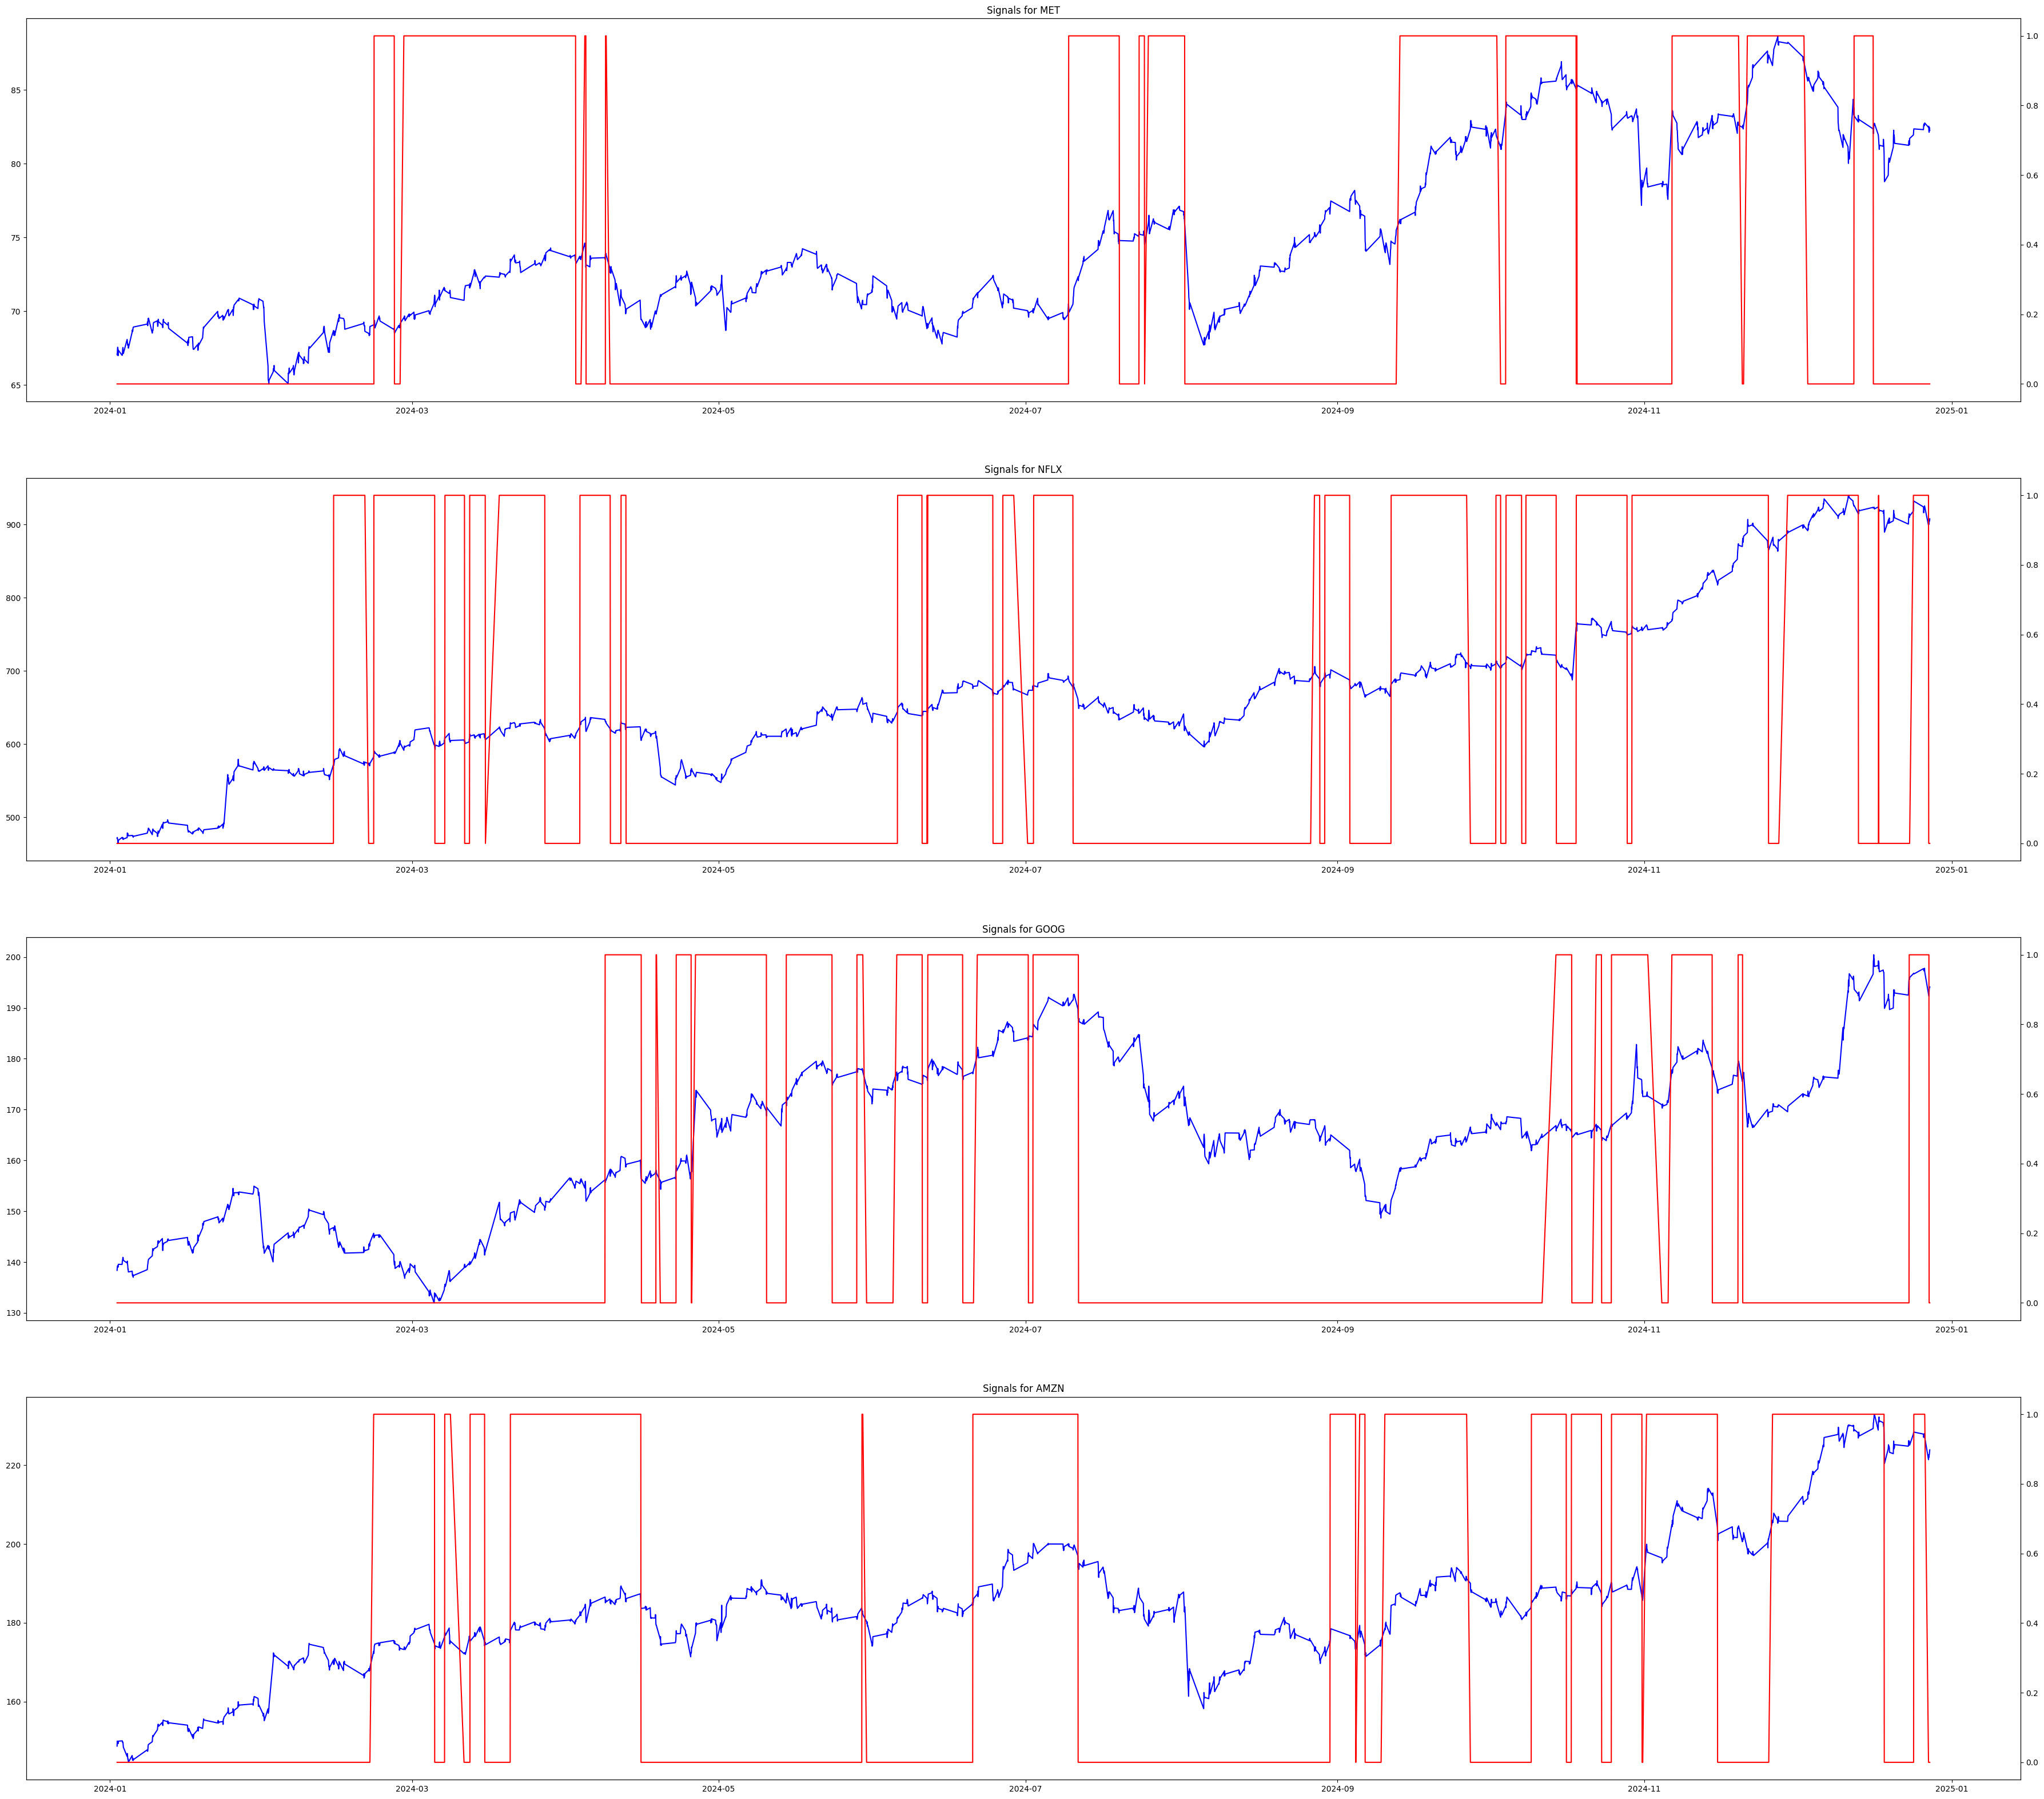

In [6]:
backtester.plot_signals()

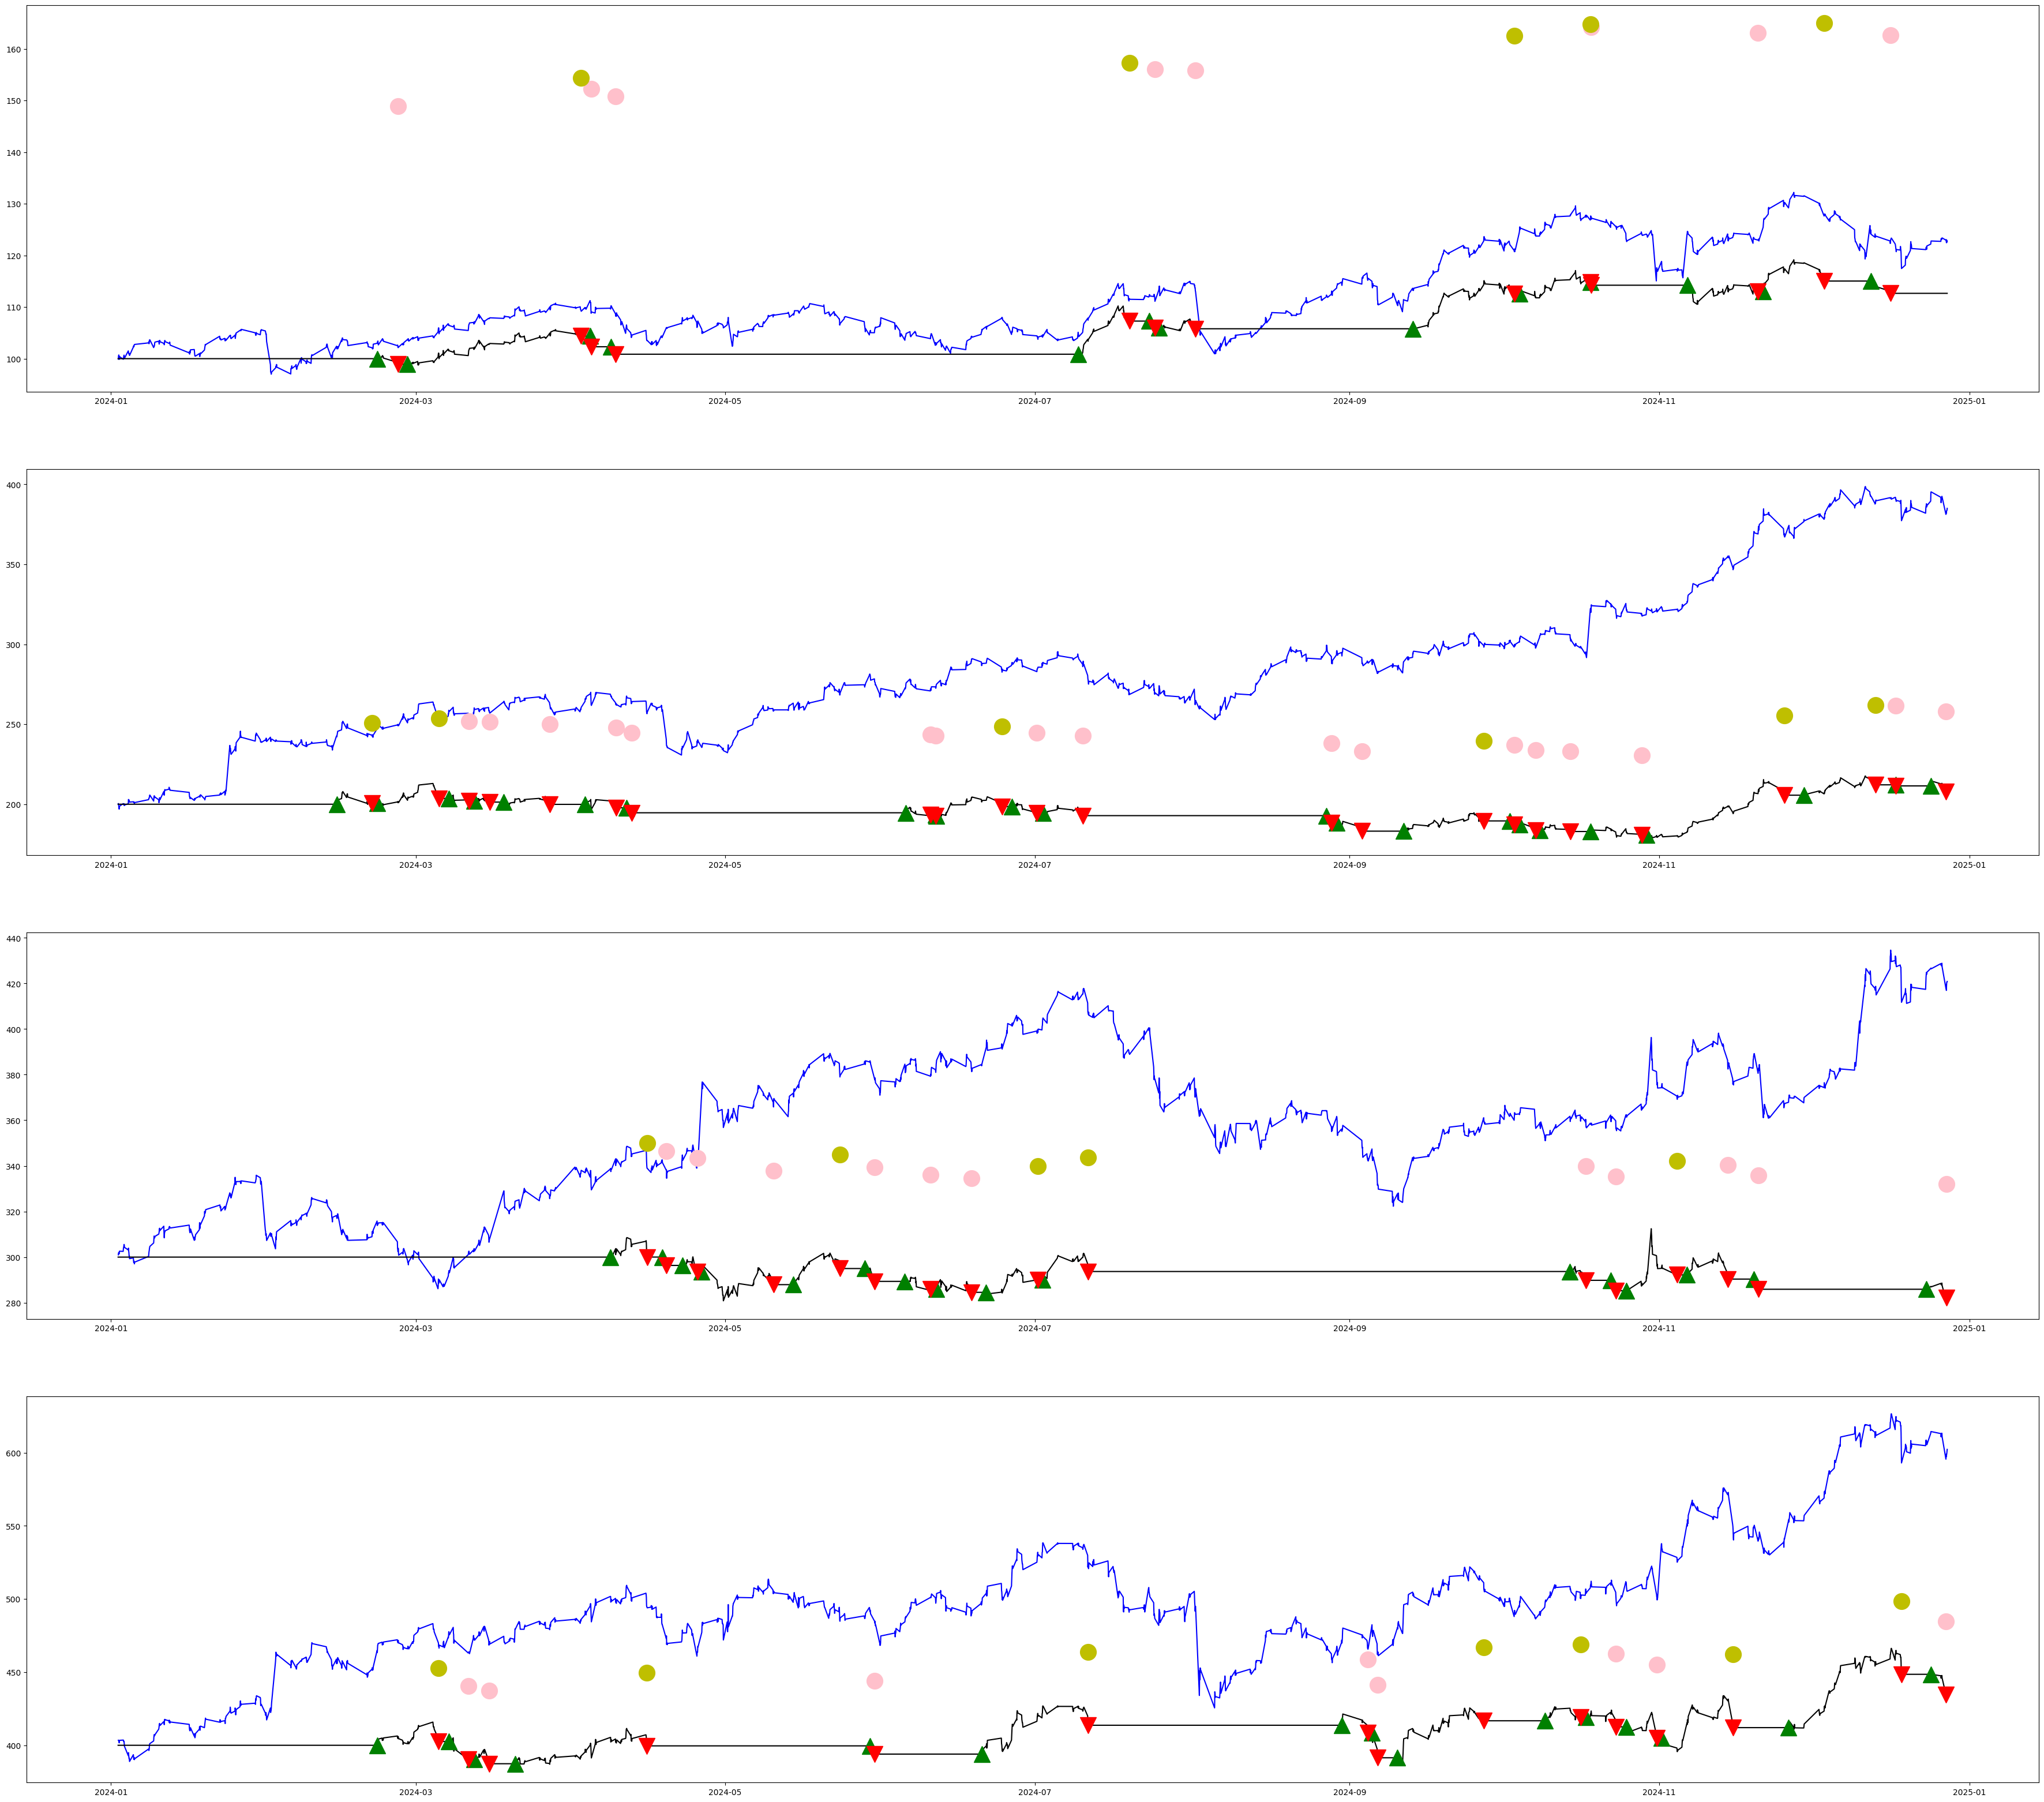

In [7]:
backtester.plot_returns_for_assets()

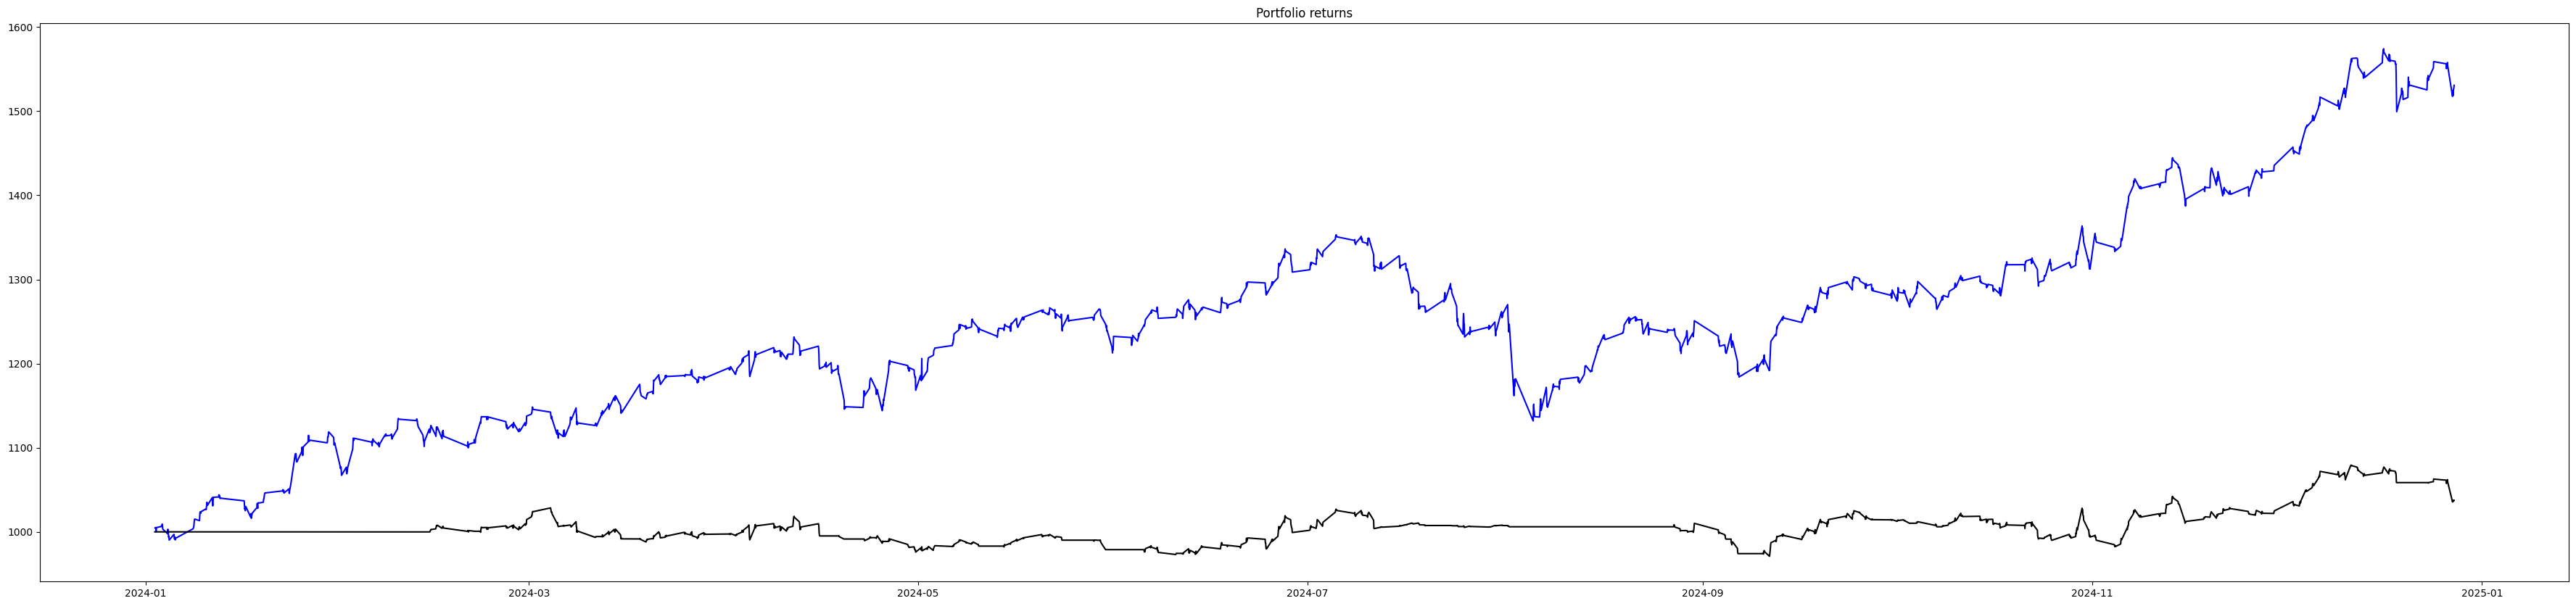

In [8]:
backtester.plot_portfolio_returns()

In [11]:
print(backtester.portfolio_cumulative_strategy_returns[-1] - backtester.portfolio_cumulative_strategy_returns[0])
print(sum(portfolio.asset_allocation.values())-1000)

37.41283060829937
37.41283060829892


/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_65447/1643030219.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(backtester.portfolio_cumulative_strategy_returns[-1] - backtester.portfolio_cumulative_strategy_returns[0])
